### Naive Bayes

En este notebook entrenaremos tres modelos de MultinomialNB, uno con el mismo preprocesamiento del dataset realizado en la primera parte del TP, el segundo con la función `preprocessing_significantes`, y el último con el `preprocessing_equilibrado`, para estudiar cómo se comporta este modelo ante esas tres distribuciones.

In [2]:
# Modelo
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB
from sklearn.naive_bayes import BernoulliNB, ComplementNB

# Preprocessing
import utils
import preprocessing
from sklearn.preprocessing import MinMaxScaler

# Búsqueda
from sklearn.model_selection import train_test_split, GridSearchCV

# Metrics
from sklearn.metrics import plot_roc_curve, roc_auc_score
from sklearn.metrics import classification_report, plot_confusion_matrix

# Plots
from matplotlib import pyplot as plt
import seaborn as sns

# Otros
import pandas as pd
import numpy as np

Como siempre, comencemos por obtener el dataset

In [3]:
df = utils.get_data()

### Preprocessing base

En este modelo en particular, nos interesa entrenar modelos con distintos valores del hiperparámetro alpha, que haremos variar entre 0 y 1.

In [4]:
params = { 'alpha': np.linspace(0,1,1000) }
model = MultinomialNB()

In [5]:
gscv = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, verbose=10)

Separamos los datos, los preprocesamos con la primer función que mostraremos en este notebook, y escalamos los valores obtenidos entre 0 y 1 antes de entrenar.

In [6]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df.drop('tiene_alto_valor_adquisitivo',1), df['tiene_alto_valor_adquisitivo'], random_state=112, stratify=df['tiene_alto_valor_adquisitivo'])
X_train_1, X_test_1 = preprocessing.preprocessing_base_parte_1(X_train_1, X_test_1)

In [7]:
scaler = MinMaxScaler() # Por default, en [0,1]

X_train_1 = pd.DataFrame(scaler.fit_transform(X_train_1))
X_test_1 = pd.DataFrame(scaler.transform(X_test_1))

In [8]:
%%time
gscv.fit(X_train_1, y_train_1)
score = roc_auc_score(y_test_1, gscv.predict_proba(X_test_1)[:,1])

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1979s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 170 tas

CPU times: user 13.4 s, sys: 2.58 s, total: 16 s
Wall time: 44.1 s


[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   43.9s finished


In [9]:
gscv.best_params_

{'alpha': 0.26926926926926925}

In [10]:
bayes_base = gscv.best_estimator_
bayes_base.fit(X_train_1, y_train_1)

MultinomialNB(alpha=0.26926926926926925)

In [11]:
score

0.8458484939033047

In [12]:
print(classification_report(y_test_1,bayes_base.predict(X_test_1)))

              precision    recall  f1-score   support

           0       0.76      1.00      0.87      6181
           1       1.00      0.02      0.03      1960

    accuracy                           0.76      8141
   macro avg       0.88      0.51      0.45      8141
weighted avg       0.82      0.76      0.66      8141



Vemos que, si bien la métrica AUC-ROC arrojó un buen resultado, el accuracy es bastante bajo, y las demás métricas nos dan una idea de que el modelo seleccionado no generaliza nada bien.

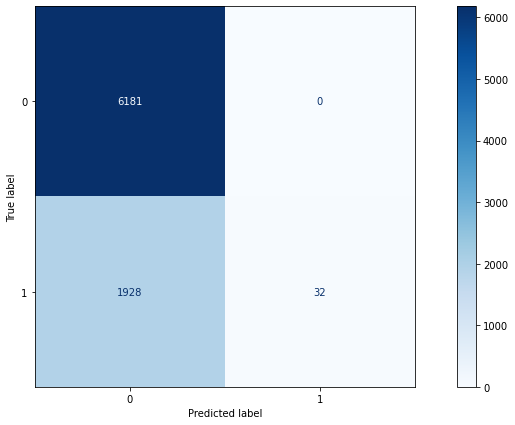

In [13]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(bayes_base, X_test_1, y_test_1, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

Si bien, a priori, parece dar buenos resultados para los True Positive y False Negative, vemos que los True Negative son muy escasos y tiene una cantidad indeseablemente alta de False Positive.

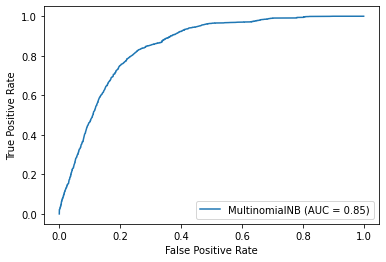

In [14]:
plot_roc_curve(bayes_base, X_test_1, y_test_1)

La forma de la curva y su lento crecimiento en el eje vertical nos ayuda a reforzar la idea de que no obtuvimos un buen clasificador.

### Preprocessing Significantes

Repetimos el procedimiento anterior, esta vez trabajando los datos con la función de preprocessing significantes para con un 90% de varianza explicada.

In [15]:
df = utils.get_data()

In [16]:
params = { 'alpha': np.linspace(0,1,1000) }
model = MultinomialNB()

In [17]:
gscv = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, verbose=10)

In [18]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
Y = df['tiene_alto_valor_adquisitivo']
X = pd.get_dummies(X, drop_first=True)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, Y, random_state=112, stratify=Y)
X_train_2, X_test_2 = preprocessing.preprocessing_significantes(X_train_2, X_test_2, 0.9)

/home/lukas/FIUBA/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ganancia_perdida_declarada_bolsa_argentina'] = X_train['ganancia_perdida_declarada_bolsa_argentina'].apply(_log_scale)
/home/lukas/FIUBA/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ganancia_perdida_declarada_bolsa_argentina'] = X_test['ganancia_perdida_declarada_bolsa_argentina'].apply(

In [19]:
scaler = MinMaxScaler() # Por default, en [0,1]

X_train_2 = pd.DataFrame(scaler.fit_transform(X_train_2))
X_test_2 = pd.DataFrame(scaler.transform(X_test_2))

In [20]:
%%time
gscv.fit(X_train_2, y_train_2)
score = roc_auc_score(y_test_2, gscv.predict_proba(X_test_2)[:,1])

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1385s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 314 tas

CPU times: user 19.1 s, sys: 3.35 s, total: 22.5 s
Wall time: 1min 23s


In [21]:
gscv.best_params_

{'alpha': 0.015015015015015015}

Antes de continuar, notemos que el alpha obtenido en este caso es muy chico, en comparación con el seleccionado para el modelo anterior que era bastante cercano a 1.

In [22]:
score

0.8682085324017974

In [23]:
bayes_significantes = gscv.best_estimator_
bayes_significantes.fit(X_train_2, y_train_2)

MultinomialNB(alpha=0.015015015015015015)

Vemos una mejora en la métrica AUC-ROC

In [24]:
print(classification_report(y_test_2,bayes_significantes.predict(X_test_2)))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      6181
           1       0.00      0.00      0.00      1960

    accuracy                           0.76      8141
   macro avg       0.38      0.50      0.43      8141
weighted avg       0.58      0.76      0.66      8141



/home/lukas/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Nuevamente, a pesar de haber obtenido un resultado decente según AUC-ROC, vemos que la clasificación es muy mala.

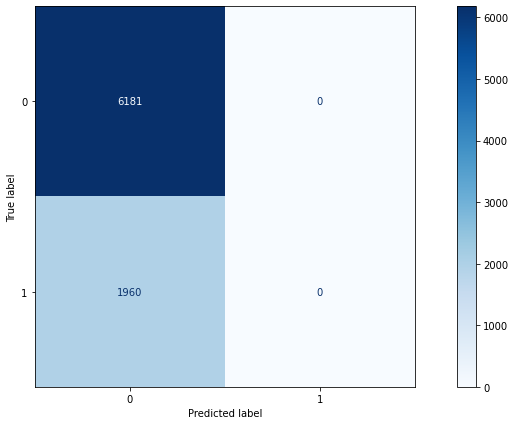

In [25]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(bayes_significantes, X_test_2, y_test_2, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

Vemos que el comportamiento es incluso peor que el modelo anterior.

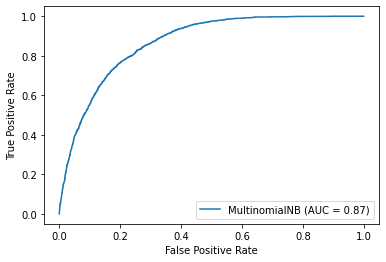

In [26]:
plot_roc_curve(bayes_significantes, X_test_2, y_test_2)

### Preprocessing Equilibrado

Finalizaremos este análisis intentando obtener un mejor resultado al equilibrar la cantidad de muestras con bajo poder adquisitivo a la de muestras con alto poder adquisitivo.

In [27]:
df = utils.get_data()

In [28]:
params = { 'alpha': np.linspace(0,1,1000) }
model = MultinomialNB()

In [29]:
gscv = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, verbose=10)

In [55]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
Y = df['tiene_alto_valor_adquisitivo']
X = pd.get_dummies(X)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, Y, random_state=112)
X_train_3, X_test_3, y_train_3, y_test_3 = preprocessing.preprocessing_equilibrado(X_train_3, X_test_3, y_train_3, y_test_3)

In [56]:
scaler_train = MinMaxScaler() # Por default, en [0,1]
scaler_test = MinMaxScaler() # Por default, en [0,1]

X_train_3 = pd.DataFrame(scaler_train.fit_transform(X_train_3))
X_test_3 = pd.DataFrame(scaler_test.fit_transform(X_test_3))

In [57]:
%%time
gscv.fit(X_train_3, y_train_3)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0715s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1971s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    2.8s
[Parallel(n_jo

CPU times: user 7.3 s, sys: 999 ms, total: 8.3 s
Wall time: 36.9 s


GridSearchCV(estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02...
       0.96596597, 0.96696697, 0.96796797, 0.96896897, 0.96996997,
       0.97097097, 0.97197197, 0.97297297, 0.97397397, 0.97497497,
       0.97597598, 0.97697698, 0.97797798, 0.97897898, 0.97997998,
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ])},
             scoring='roc_auc', verbose=10)

In [58]:
gscv.best_params_

{'alpha': 0.6746746746746747}

Vemos que el alpha seleccionado está casi en el límite superior del rango elegido.

In [59]:
bayes_equilibrado = gscv.best_estimator_
bayes_equilibrado.fit(X_train_3, y_train_3)

MultinomialNB(alpha=0.6746746746746747)

In [60]:
print(classification_report(y_test_3,bayes_equilibrado.predict(X_test_3)))

              precision    recall  f1-score   support

           0       0.94      0.69      0.80      6182
           1       0.47      0.85      0.60      1959

    accuracy                           0.73      8141
   macro avg       0.70      0.77      0.70      8141
weighted avg       0.82      0.73      0.75      8141



Si bien sigue sin ser un clasificador excelente, vemos una mejora sustancial respecto de los anteriores, al menos en términos de la generalización. Sin embargo, el accuracy empeoró.

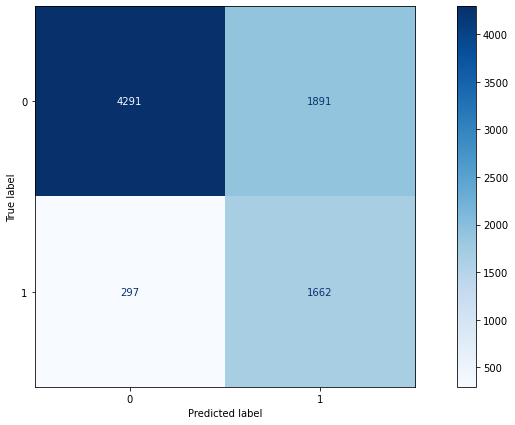

In [61]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(bayes_equilibrado, X_test_3, y_test_3, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

A pesar de haber mejorado en algunos aspectos, ahora tenemos un número demasiado alto en los False Negatives

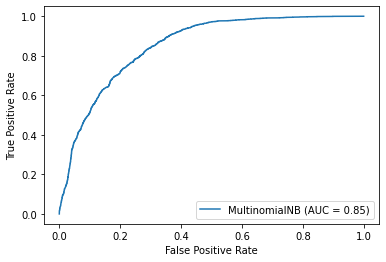

In [62]:
plot_roc_curve(bayes_equilibrado, X_test_3, y_test_3)

Nuevamente, vemos que los falsos positivos crecen muy rápido en comparación con los verdaderos positivos, haciendo que la clasificación sea tan pobre como vimos.

A modo de conclusión general, no vemos que MultinomialNB sea un modelo interesante para los objetivos de este trabajo.

# Persistiendo los modelos

In [63]:
import pickle

In [64]:
pickle.dump(bayes_base, open("Modelos/MultinomialNB/bayes_base.pickle", "wb"))
pickle.dump(bayes_significantes, open("Modelos/MultinomialNB/bayes_significantes.pickle", "wb"))
pickle.dump(bayes_equilibrado, open("Modelos/MultinomialNB/bayes_equilibrado.pickle", "wb"))

# Predicción de HoldOut

Usaremos para predecir el NaiveBayes obtenido para el preprocessing significantes de 90%

In [65]:
bayes_significantes = pickle.load(open("Modelos/MultinomialNB/bayes_significantes.pickle", "rb"))

In [66]:
def holdout():
    dfv = utils.get_data()
    Xv = dfv[dfv.columns.drop('tiene_alto_valor_adquisitivo')]
    Xv = pd.get_dummies(Xv, drop_first=True)
    Xv, _, _, _ = train_test_split(Xv, dfv['tiene_alto_valor_adquisitivo'], random_state=112, stratify=dfv['tiene_alto_valor_adquisitivo'])

    ids, X = utils.get_holdout_data()
    X = pd.get_dummies(X, drop_first=True)

    notInHoldout=[]
    for c in Xv.columns:
        if c not in X.columns:
            notInHoldout.append(c)
    X[notInHoldout] = 0

    Xv, X = preprocessing.preprocessing_significantes(Xv, X, variance=0.9)
    return ids, X

In [ ]:
ids, X = holdout()

In [ ]:
utils.escribir_holdout(bayes_significantes.predict(X), "3 - MultinomialNB", ids)